In [1]:
import torch
import torch.nn.functional as F
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import tifffile as tiff
import cv2

In [2]:
data_path = Path("../data/")
os.listdir(data_path)

['train_images',
 'test_images',
 'train_annotations',
 'train.csv',
 'sample_submission.csv',
 'test.csv']

In [3]:
train_images_path = data_path / "train_images"

In [4]:
train_df = pd.read_csv(data_path / "train.csv")
train_df['path'] = train_df.id.apply(lambda x: f'{str(train_images_path)}/{x}.tiff')
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,path
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../data/train_images/10044.tiff
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,../data/train_images/10274.tiff
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,../data/train_images/10392.tiff
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,../data/train_images/10488.tiff
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,../data/train_images/10610.tiff


## View sample

In [5]:
idx = randint(0, len(train_df) - 1)

In [6]:
sample_img_path = train_df.iloc[idx].path
sample_img_path

'../data/train_images/9470.tiff'

In [7]:
sample_img_tiff = tiff.imread(sample_img_path)
type(sample_img_tiff), sample_img_tiff.shape, sample_img_tiff.dtype, sample_img_tiff.min(), sample_img_tiff.max()

(numpy.ndarray, (3000, 3000, 3), dtype('uint8'), 13, 245)

In [8]:
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    if len(shape) == 3:
        img = img.reshape(shape[0], shape[1])
    else:
        img = img.reshape(shape[0], shape[1])
    return img.T

In [9]:
sample_img_tiff_mask = rle2mask(train_df.iloc[idx].rle, sample_img_tiff.shape)
type(sample_img_tiff_mask), sample_img_tiff_mask.shape, sample_img_tiff_mask.dtype, sample_img_tiff_mask.min(), sample_img_tiff_mask.max()

(numpy.ndarray, (3000, 3000), dtype('uint8'), 0, 1)

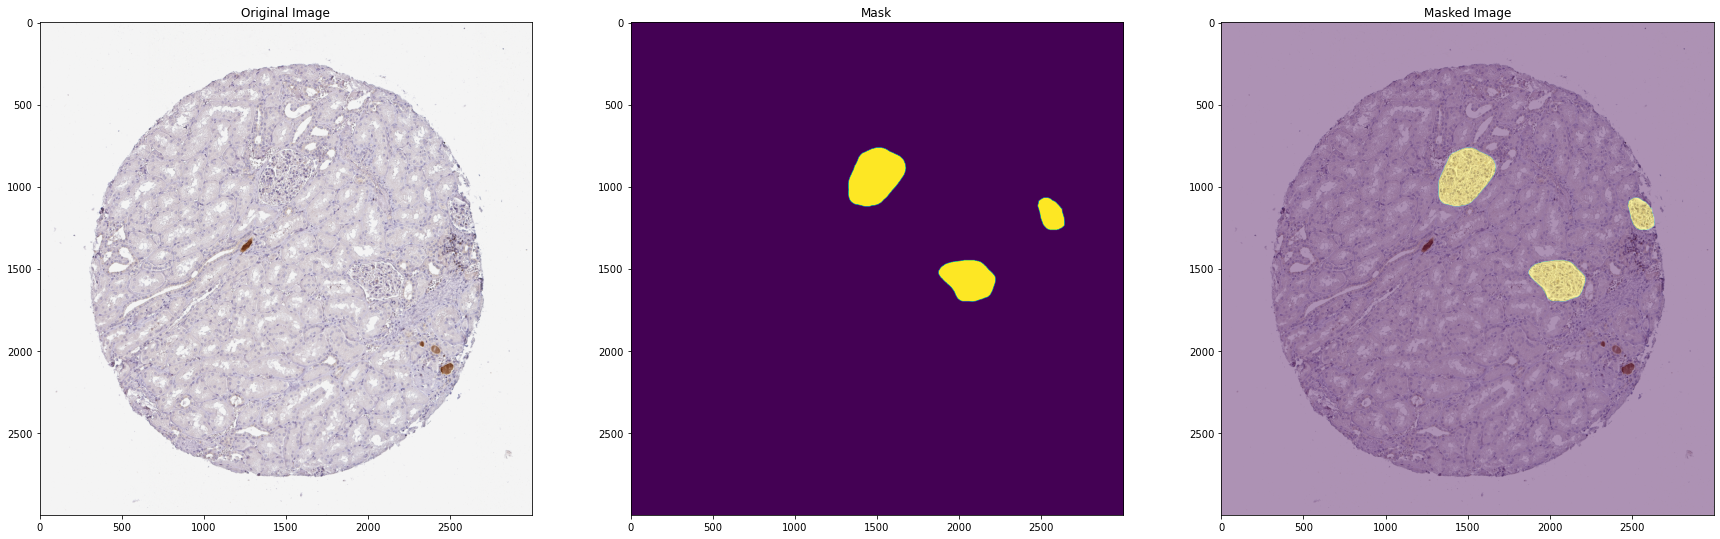

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(sample_img_tiff)
ax1.set_title('Original Image')
ax2.imshow(sample_img_tiff_mask)
ax2.set_title('Mask')
ax3.imshow(sample_img_tiff)
ax3.imshow(sample_img_tiff_mask, alpha=0.4)
ax3.set_title('Masked Image')
plt.show()

In [11]:
sample_img_tiff_mask_oh = np.eye(2)[sample_img_tiff_mask.astype(int)].astype(np.float32)
type(sample_img_tiff_mask_oh), sample_img_tiff_mask_oh.shape, sample_img_tiff_mask_oh.dtype, sample_img_tiff_mask_oh.min(), sample_img_tiff_mask_oh.max()

(numpy.ndarray, (3000, 3000, 2), dtype('float32'), 0.0, 1.0)

## Resize image

In [14]:
sample_img_cv = cv2.imread(sample_img_path)
sample_img_cv = cv2.cvtColor(sample_img_cv, cv2.COLOR_BGR2RGB)
dim = 2000
reshape = (dim, dim)
tipe = cv2.INTER_LANCZOS4
sample_img_cv_res = cv2.resize(sample_img_cv, dsize=reshape, interpolation=tipe)
sample_img_cv_res_norm = sample_img_cv_res / 255
type(sample_img_cv_res_norm), sample_img_cv_res_norm.shape, sample_img_cv_res_norm.dtype, sample_img_cv_res_norm.min(), sample_img_cv_res_norm.max()

(numpy.ndarray, (2000, 2000, 3), dtype('float64'), 0.050980392156862744, 1.0)

In [15]:
sample_img_cv_mask = rle2mask(train_df.iloc[idx].rle, sample_img_cv.shape)
sample_img_cv_mask_res = cv2.resize(sample_img_cv_mask, dsize=reshape, interpolation=tipe)
type(sample_img_cv_mask_res), sample_img_cv_mask_res.shape, sample_img_cv_mask_res.dtype, sample_img_cv_mask_res.min(), sample_img_cv_mask_res.max()

(numpy.ndarray, (2000, 2000), dtype('uint8'), 0, 1)

In [22]:
sample_img_cv_mask_oh = np.eye(2)[sample_img_cv_mask_res.astype(int)].astype(np.float32)
type(sample_img_cv_mask_oh), sample_img_cv_mask_oh.shape, sample_img_cv_mask_oh.dtype, sample_img_cv_mask_oh.min(), sample_img_cv_mask_oh.max()

(numpy.ndarray, (2000, 2000, 2), dtype('float32'), 0.0, 1.0)

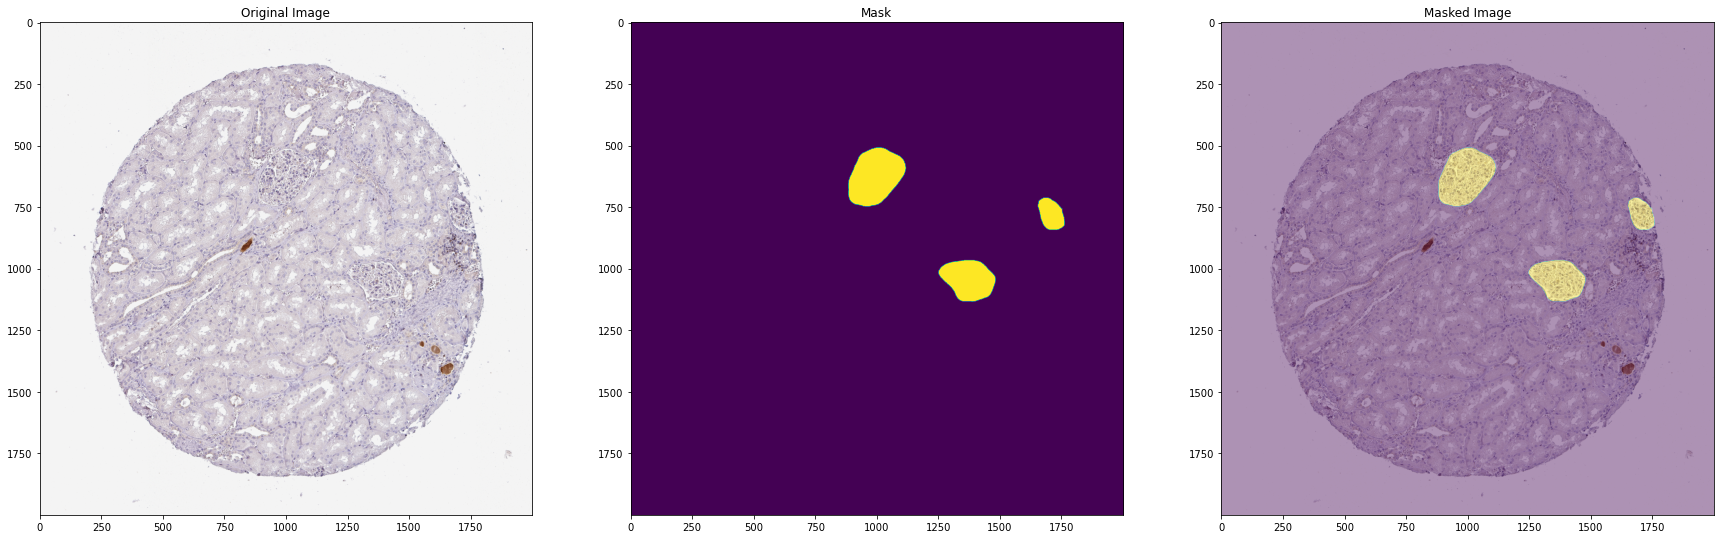

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(sample_img_cv_res_norm)
ax1.set_title('Original Image')
ax2.imshow(sample_img_cv_mask_res)
ax2.set_title('Mask')
ax3.imshow(sample_img_cv_res_norm)
ax3.imshow(sample_img_cv_mask_res, alpha=0.4)
ax3.set_title('Masked Image')
plt.show()

## UNet from scratch

In [17]:
number_of_classes = sample_img_tiff_mask.max() + 1 # 2 classes
number_of_channels = 3

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=number_of_classes, in_ch=number_of_channels):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

try model with random tensor

In [18]:
model = UNet()
output = model(torch.randn((10,3,300,300)))
output.shape

torch.Size([10, 2, 300, 300])

## Fit of one sample

In [19]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def fit(model, X, y, epochs=1, lr=3e-4, parallel=False):
    len_int_epochs = len(str(epochs))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    if parallel:
        model = torch.nn.DataParallel(model)
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        if len_int_epochs == 1:
            print(f"Epoch {(epoch+1):01d}/{epochs:01d} loss {loss.item():.5f}")
        elif len_int_epochs == 2:
            print(f"Epoch {(epoch+1):02d}/{epochs:02d} loss {loss.item():.5f}")
        elif len_int_epochs == 3:
            print(f"Epoch {(epoch+1):03d}/{epochs:03d} loss {loss.item():.5f}")
        elif len_int_epochs == 4:
            print(f"Epoch {(epoch+1):04d}/{epochs:04d} loss {loss.item():.5f}")

In [20]:
sample_img_tensor = torch.from_numpy(sample_img_cv_res_norm).float()
print(sample_img_tensor.shape, sample_img_tensor.dtype, sample_img_tensor.min(), sample_img_tensor.max())
sample_img_tensor = sample_img_tensor.permute(2, 0, 1)
print(sample_img_tensor.shape, sample_img_tensor.dtype, sample_img_tensor.min(), sample_img_tensor.max())
sample_img_tensor = sample_img_tensor.unsqueeze(0)
print(sample_img_tensor.shape, sample_img_tensor.dtype, sample_img_tensor.min(), sample_img_tensor.max())

torch.Size([2000, 2000, 3]) torch.float32 tensor(0.0510) tensor(1.)
torch.Size([3, 2000, 2000]) torch.float32 tensor(0.0510) tensor(1.)
torch.Size([1, 3, 2000, 2000]) torch.float32 tensor(0.0510) tensor(1.)


In [23]:
sample_img_tiff_mask_tensor = torch.from_numpy(sample_img_cv_mask_oh).float()
print(sample_img_tiff_mask_tensor.shape, sample_img_tiff_mask_tensor.dtype, sample_img_tiff_mask_tensor.min(), sample_img_tiff_mask_tensor.max())
sample_img_tiff_mask_tensor = sample_img_tiff_mask_tensor.permute(2, 0, 1)
print(sample_img_tiff_mask_tensor.shape, sample_img_tiff_mask_tensor.dtype, sample_img_tiff_mask_tensor.min(), sample_img_tiff_mask_tensor.max())
sample_img_tiff_mask_tensor = sample_img_tiff_mask_tensor.unsqueeze(0)
print(sample_img_tiff_mask_tensor.shape, sample_img_tiff_mask_tensor.dtype, sample_img_tiff_mask_tensor.min(), sample_img_tiff_mask_tensor.max())

torch.Size([2000, 2000, 2]) torch.float32 tensor(0.) tensor(1.)
torch.Size([2, 2000, 2000]) torch.float32 tensor(0.) tensor(1.)
torch.Size([1, 2, 2000, 2000]) torch.float32 tensor(0.) tensor(1.)


In [24]:
model = UNet()
fit(model, sample_img_tensor, sample_img_tiff_mask_tensor, epochs=200, parallel=True)

Epoch 001/200 loss 0.76358
Epoch 002/200 loss 0.74735
Epoch 003/200 loss 0.73450
Epoch 004/200 loss 0.72268
Epoch 005/200 loss 0.71134
Epoch 006/200 loss 0.69974
Epoch 007/200 loss 0.68884
Epoch 008/200 loss 0.67802
Epoch 009/200 loss 0.66712
Epoch 010/200 loss 0.65668
Epoch 011/200 loss 0.64632
Epoch 012/200 loss 0.63611
Epoch 013/200 loss 0.62615
Epoch 014/200 loss 0.61622
Epoch 015/200 loss 0.60637
Epoch 016/200 loss 0.59672
Epoch 017/200 loss 0.58720
Epoch 018/200 loss 0.57772
Epoch 019/200 loss 0.56844
Epoch 020/200 loss 0.55938
Epoch 021/200 loss 0.55051
Epoch 022/200 loss 0.54178
Epoch 023/200 loss 0.53327
Epoch 024/200 loss 0.52498
Epoch 025/200 loss 0.51674
Epoch 026/200 loss 0.50892
Epoch 027/200 loss 0.50117
Epoch 028/200 loss 0.49361
Epoch 029/200 loss 0.48615
Epoch 030/200 loss 0.47893
Epoch 031/200 loss 0.47202
Epoch 032/200 loss 0.46514
Epoch 033/200 loss 0.45851
Epoch 034/200 loss 0.45205
Epoch 035/200 loss 0.44573
Epoch 036/200 loss 0.43955
Epoch 037/200 loss 0.43351
E

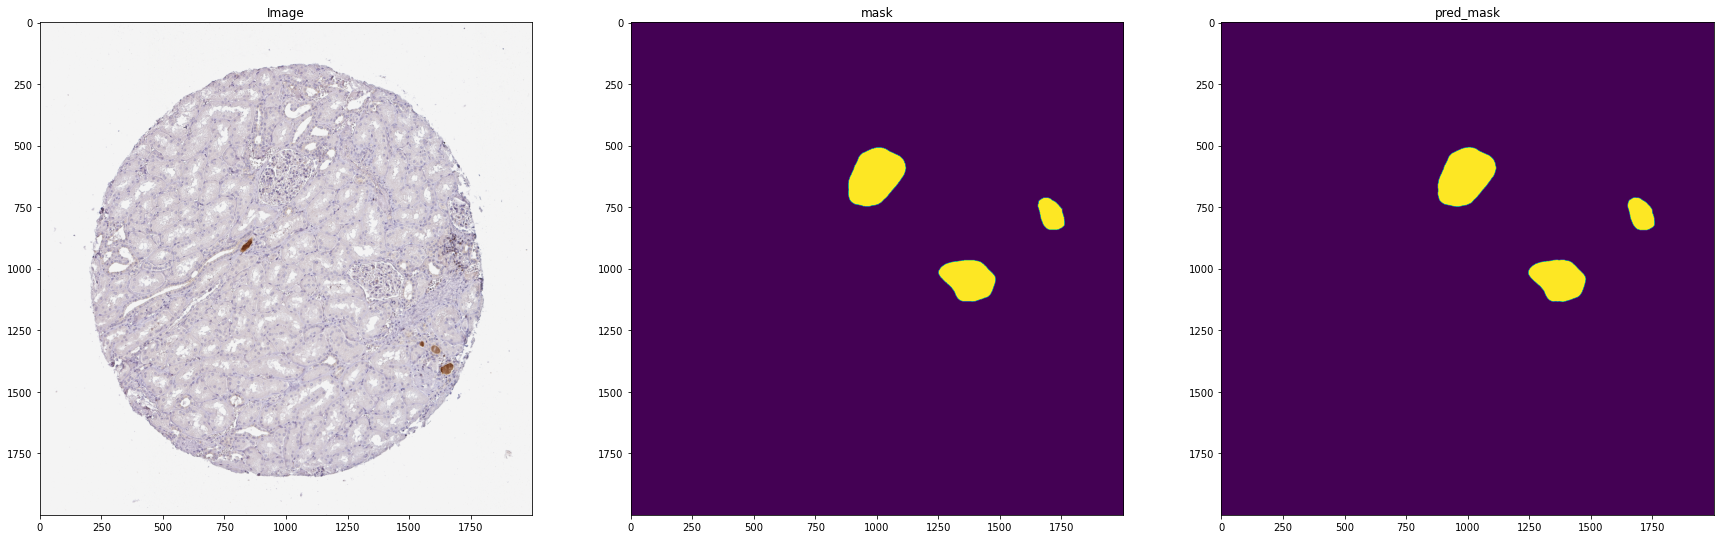

output.shape = torch.Size([2, 2000, 2000]), pred_mask.shape = torch.Size([2000, 2000])


In [25]:
model.eval()
with torch.no_grad():
    output = model(sample_img_tensor.to(device))[0]
    pred_mask = torch.argmax(output, axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(sample_img_cv_res_norm)
ax1.set_title('Image')
ax2.imshow(sample_img_cv_mask_res)
ax2.set_title('mask')
ax3.imshow(pred_mask.squeeze().cpu().numpy())
ax3.set_title('pred_mask')
plt.show()
print(f"output.shape = {output.shape}, pred_mask.shape = {pred_mask.shape}")

## Using Dice coefficient loss

In [26]:
def dice_coeff(pred, target):
    smooth = 1.
    num = pred.size(1)
    m1 = pred.view(num, -1).float()  # Flatten
    m2 = target.view(num, -1).float()  # Flatten
    intersection = (m1 * m2).sum().float()
    dice = (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)
    dice = dice.item()

    return dice

In [27]:
def fit(model, X, y, epochs=1, lr=1e-3, parallel=False):
    len_int_epochs = len(str(epochs))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    if parallel:
        model = torch.nn.DataParallel(model)
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        dice = dice_coeff(y_hat, y)
        if len_int_epochs == 1:
            print(f"Epoch {(epoch+1):01d}/{epochs:01d} loss {loss.item():.5f}, dice {dice:.5f}")
        elif len_int_epochs == 2:
            print(f"Epoch {(epoch+1):02d}/{epochs:02d} loss {loss.item():.5f}, dice {dice:.5f}")
        elif len_int_epochs == 3:
            print(f"Epoch {(epoch+1):03d}/{epochs:03d} loss {loss.item():.5f}, dice {dice:.5f}")
        elif len_int_epochs == 4:
            print(f"Epoch {(epoch+1):04d}/{epochs:04d} loss {loss.item():.5f}, dice {dice:.5f}")

In [28]:
model = UNet()
fit(model, sample_img_tensor, sample_img_tiff_mask_tensor, epochs=200, parallel=True)

Epoch 001/200 loss 0.70349, dice -0.70458
Epoch 002/200 loss 0.66768, dice -0.50512
Epoch 003/200 loss 0.63258, dice -0.21468
Epoch 004/200 loss 0.59835, dice 0.02888
Epoch 005/200 loss 0.56822, dice 0.26218
Epoch 006/200 loss 0.53934, dice 0.50768
Epoch 007/200 loss 0.51298, dice 0.74929
Epoch 008/200 loss 0.48678, dice 1.01454
Epoch 009/200 loss 0.46100, dice 1.30523
Epoch 010/200 loss 0.43563, dice 1.62222
Epoch 011/200 loss 0.41011, dice 1.97096
Epoch 012/200 loss 0.38530, dice 2.34427
Epoch 013/200 loss 0.36298, dice 2.72809
Epoch 014/200 loss 0.34308, dice 3.11140
Epoch 015/200 loss 0.32482, dice 3.52736
Epoch 016/200 loss 0.30765, dice 3.93298
Epoch 017/200 loss 0.29010, dice 4.35463
Epoch 018/200 loss 0.27311, dice 4.79742
Epoch 019/200 loss 0.25821, dice 5.23307
Epoch 020/200 loss 0.24349, dice 5.73109
Epoch 021/200 loss 0.22986, dice 6.22357
Epoch 022/200 loss 0.21666, dice 6.71545
Epoch 023/200 loss 0.20476, dice 7.18631
Epoch 024/200 loss 0.19305, dice 7.64390
Epoch 025/200

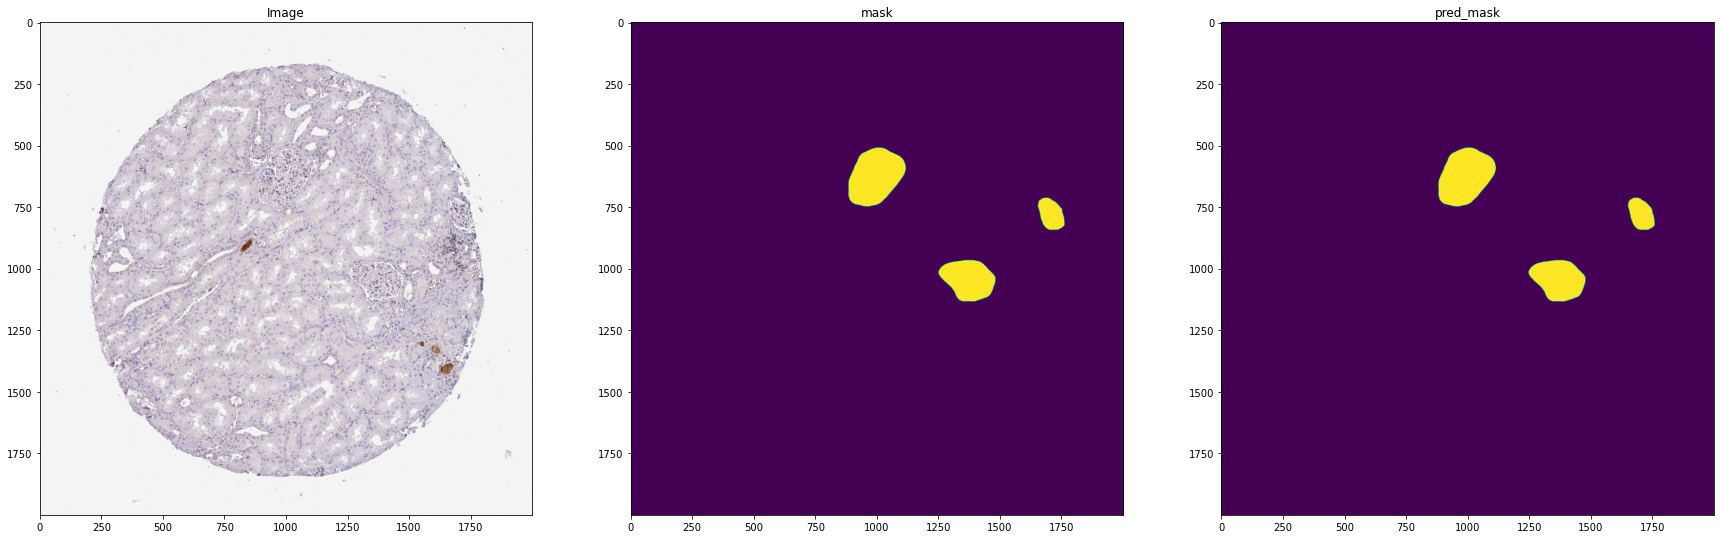

output.shape = torch.Size([2, 2000, 2000]), pred_mask.shape = torch.Size([2000, 2000])


In [29]:
model.eval()
with torch.no_grad():
    output = model(sample_img_tensor.to(device))[0]
    pred_mask = torch.argmax(output, axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(sample_img_cv_res)
ax1.set_title('Image')
ax2.imshow(sample_img_cv_mask_res)
ax2.set_title('mask')
ax3.imshow(pred_mask.squeeze().cpu().numpy())
ax3.set_title('pred_mask')
plt.show()
print(f"output.shape = {output.shape}, pred_mask.shape = {pred_mask.shape}")

## Train all images

In [30]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, dataframe, n_classes=2, dim=2000, interpolation=cv2.INTER_LANCZOS4):
    self.dataframe = dataframe
    self.n_classes = n_classes
    self.dim = dim
    self.interpolation = interpolation

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, ix):
    # Get image path from column 'path' in dataframe
    img_path = str(self.dataframe.iloc[ix]['path'])
    # Load image
    img_cv = cv2.imread(img_path)
    img_cv = cv2.cvtColor(sample_img_cv, cv2.COLOR_BGR2RGB)
    # Resize image
    img_cv_res = cv2.resize(img_cv, dsize=(self.dim, self.dim), interpolation=self.interpolation)
    # Normalize image
    img_cv_res_norm = img_cv_res / 255.0
    # Convert to tensor
    img_tensor = torch.from_numpy(img_cv_res_norm).float().permute(2, 0, 1)

    # Get mask
    rle = self.dataframe.iloc[ix]['rle']
    mask_cv = rle2mask(rle, img_cv.shape)
    # Resize mask
    mask_cv_res = cv2.resize(mask_cv, dsize=(self.dim, self.dim), interpolation=self.interpolation)
    # One-hot encode mask
    mask_oh = np.eye(2)[mask_cv_res.astype(int)].astype(np.float32)
    # Convert to tensor
    mask_tensor = torch.from_numpy(mask_oh).float().permute(2, 0, 1)
    
    return img_tensor, mask_tensor

In [31]:
division = 300
resize_img = 300
dataset = {
    'train': Dataset(train_df[:division], n_classes=2, dim=resize_img),
    'val': Dataset(train_df[division:], n_classes=2, dim=resize_img),
}

print(f"Había {len(train_df)} imágenes en el dataset, lo hemos dividido en {len(dataset['train'])} imágenes de entrenamiento y {len(dataset['val'])} imágenes de validación")

Había 351 imágenes en el dataset, lo hemos dividido en 300 imágenes de entrenamiento y 51 imágenes de validación


In [32]:
BS_train = 4
BS_val = 16
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BS_train, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['val'], batch_size=BS_val, pin_memory=True)
}

In [33]:
sample_train_img, sample_train_mask = next(iter(dataloader['train']))
sample_val_img, sample_val_mask = next(iter(dataloader['test']))

sample_train_img.shape, sample_train_mask.shape

(torch.Size([4, 3, 300, 300]), torch.Size([4, 2, 300, 300]))

In [34]:
one_sample_img = sample_train_img[0]
one_sample_mask = sample_train_mask[0]

print(f"one_sample_img.shape = {one_sample_img.shape}, one_sample_img.dtype = {one_sample_img.dtype}, one_sample_img.max() = {one_sample_img.max()}, one_sample_img.min() = {one_sample_img.min()}")
print(f"one_sample_mask.shape = {one_sample_mask.shape}, one_sample_mask.dtype = {one_sample_mask.dtype}, one_sample_mask.max() = {one_sample_mask.max()}, one_sample_mask.min() = {one_sample_mask.min()}")

one_sample_img.shape = torch.Size([3, 300, 300]), one_sample_img.dtype = torch.float32, one_sample_img.max() = 1.0, one_sample_img.min() = 0.054901961237192154
one_sample_mask.shape = torch.Size([2, 300, 300]), one_sample_mask.dtype = torch.float32, one_sample_mask.max() = 1.0, one_sample_mask.min() = 0.0


In [35]:
from tqdm import tqdm

def fit(model, dataloader, epochs=100, lr=3e-4, parallel=False):
    len_int_epochs = len(str(epochs))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    if parallel:
        model = torch.nn.DataParallel(model)
    model.to(device)
    hist = {'loss': [], 'dice': [], 'test_loss': [], 'test_dice': []}
    for epoch in range(epochs):
        bar = tqdm(dataloader['train'])
        train_loss, train_dice = [], []
        model.train()
        for imgs, masks in bar:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            pred_mask = model(imgs)
            loss = criterion(pred_mask, masks)
            loss.backward()
            optimizer.step()
            dice = dice_coeff(pred_mask, masks)
            train_loss.append(loss.item())
            train_dice.append(dice)
            bar.set_description(f"\t\tloss {np.mean(train_loss):.5f}, dice {np.mean(train_dice):.5f}")
        hist['loss'].append(np.mean(train_loss))
        hist['dice'].append(np.mean(train_dice))
        bar = tqdm(dataloader['test'])
        test_loss, test_dice = [], []
        model.eval()
        with torch.no_grad():
            for imgs, masks in bar:
                imgs, masks = imgs.to(device), masks.to(device)
                pred_mask = model(imgs)
                loss = criterion(pred_mask, masks)
                dice = dice_coeff(pred_mask, masks)
                test_loss.append(loss.item())
                test_dice.append(dice)
                bar.set_description(f"\t\ttest_loss {np.mean(test_loss):.5f} test_dice {np.mean(test_dice):.5f}")
        hist['test_loss'].append(np.mean(test_loss))
        hist['test_dice'].append(np.mean(test_dice))
        if len_int_epochs == 1:
            print(f"Epoch {(epoch+1):01d}/{epochs:01d} loss {np.mean(train_loss):.5f} dice {np.mean(train_dice):.5f} test_loss {np.mean(test_loss):.5f} test_dice {np.mean(test_dice):.5f}")
        elif len_int_epochs == 2:
            print(f"Epoch {(epoch+1):02d}/{epochs:02d} loss {np.mean(train_loss):.5f} dice {np.mean(train_dice):.5f} test_loss {np.mean(test_loss):.5f} test_dice {np.mean(test_dice):.5f}")
        elif len_int_epochs == 3:
            print(f"Epoch {(epoch+1):03d}/{epochs:03d} loss {np.mean(train_loss):.5f} dice {np.mean(train_dice):.5f} test_loss {np.mean(test_loss):.5f} test_dice {np.mean(test_dice):.5f}")
        elif len_int_epochs == 4:
            print(f"Epoch {(epoch+1):04d}/{epochs:04d} loss {np.mean(train_loss):.5f} dice {np.mean(train_dice):.5f} test_loss {np.mean(test_loss):.5f} test_dice {np.mean(test_dice):.5f}")
    return hist

In [36]:
model = UNet()
hist = fit(model, dataloader, epochs=30, parallel=True)

		test_loss 0.36934 test_dice 1.99366: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


Epoch 01/30 loss 0.56220 dice 0.70501 test_loss 0.36934 test_dice 1.99366


		test_loss 0.31086 test_dice 2.99329: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


Epoch 02/30 loss 0.34072 dice 2.30004 test_loss 0.31086 test_dice 2.99329


		test_loss 0.29249 test_dice 3.75798: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]


Epoch 03/30 loss 0.29662 dice 3.29341 test_loss 0.29249 test_dice 3.75798


		test_loss 0.29087 test_dice 4.09880: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Epoch 04/30 loss 0.28710 dice 3.91636 test_loss 0.29087 test_dice 4.09880


		test_loss 0.28953 test_dice 4.58216: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


Epoch 05/30 loss 0.28423 dice 4.30376 test_loss 0.28953 test_dice 4.58216


		test_loss 0.29060 test_dice 4.20646: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


Epoch 06/30 loss 0.28304 dice 4.57403 test_loss 0.29060 test_dice 4.20646


		test_loss 0.28844 test_dice 4.74780: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


Epoch 07/30 loss 0.28256 dice 4.71822 test_loss 0.28844 test_dice 4.74780


		test_loss 0.28948 test_dice 5.43382: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


Epoch 08/30 loss 0.28183 dice 4.84578 test_loss 0.28948 test_dice 5.43382


		test_loss 0.29062 test_dice 4.94114: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


Epoch 09/30 loss 0.28187 dice 4.95799 test_loss 0.29062 test_dice 4.94114


		test_loss 0.28805 test_dice 5.32697: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


Epoch 10/30 loss 0.28196 dice 5.01069 test_loss 0.28805 test_dice 5.32697


		test_loss 0.28771 test_dice 5.25516: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


Epoch 11/30 loss 0.28165 dice 5.09000 test_loss 0.28771 test_dice 5.25516


		test_loss 0.28771 test_dice 5.17301: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


Epoch 12/30 loss 0.28186 dice 5.13631 test_loss 0.28771 test_dice 5.17301


		test_loss 0.28861 test_dice 5.19975: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


Epoch 13/30 loss 0.28181 dice 5.13727 test_loss 0.28861 test_dice 5.19975


		test_loss 0.28777 test_dice 5.37821: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Epoch 14/30 loss 0.28128 dice 5.22330 test_loss 0.28777 test_dice 5.37821


		test_loss 0.28815 test_dice 5.23372: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


Epoch 15/30 loss 0.28110 dice 5.26306 test_loss 0.28815 test_dice 5.23372


		test_loss 0.28796 test_dice 5.40107: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]


Epoch 16/30 loss 0.28115 dice 5.26820 test_loss 0.28796 test_dice 5.40107


		test_loss 0.28652 test_dice 5.17537: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]


Epoch 17/30 loss 0.28097 dice 5.28990 test_loss 0.28652 test_dice 5.17537


		test_loss 0.28849 test_dice 5.12252: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


Epoch 18/30 loss 0.28087 dice 5.34280 test_loss 0.28849 test_dice 5.12252


		test_loss 0.28888 test_dice 5.01162: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


Epoch 19/30 loss 0.28116 dice 5.35691 test_loss 0.28888 test_dice 5.01162


		test_loss 0.28878 test_dice 5.72864: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Epoch 20/30 loss 0.28113 dice 5.31781 test_loss 0.28878 test_dice 5.72864


		test_loss 0.28748 test_dice 5.34493: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


Epoch 21/30 loss 0.28086 dice 5.36411 test_loss 0.28748 test_dice 5.34493


		test_loss 0.29050 test_dice 5.82784: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


Epoch 22/30 loss 0.28060 dice 5.35388 test_loss 0.29050 test_dice 5.82784


		test_loss 0.28688 test_dice 5.06897: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]


Epoch 23/30 loss 0.28087 dice 5.46878 test_loss 0.28688 test_dice 5.06897


		test_loss 0.28665 test_dice 5.10210: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]


Epoch 24/30 loss 0.28064 dice 5.37725 test_loss 0.28665 test_dice 5.10210


		test_loss 0.28762 test_dice 5.70105: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Epoch 25/30 loss 0.28081 dice 5.44972 test_loss 0.28762 test_dice 5.70105


		test_loss 0.28687 test_dice 5.28723: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]


Epoch 26/30 loss 0.28077 dice 5.46508 test_loss 0.28687 test_dice 5.28723


		test_loss 0.28782 test_dice 5.52054: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Epoch 27/30 loss 0.28058 dice 5.41407 test_loss 0.28782 test_dice 5.52054


		test_loss 0.28782 test_dice 5.48412: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]


Epoch 28/30 loss 0.28051 dice 5.42924 test_loss 0.28782 test_dice 5.48412


		test_loss 0.28700 test_dice 5.49758: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]


Epoch 29/30 loss 0.28065 dice 5.50044 test_loss 0.28700 test_dice 5.49758


		test_loss 0.28757 test_dice 5.70975: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]

Epoch 30/30 loss 0.28069 dice 5.51056 test_loss 0.28757 test_dice 5.70975


In [37]:
hist_df = pd.DataFrame(hist)
print(len(hist_df))
hist_df.head()

30


,loss,dice,test_loss,test_dice
0,0.562202,0.705012,0.369344,1.993657
1,0.340724,2.300038,0.310860,2.993291
2,0.296624,3.293410,0.292493,3.757983
3,0.287101,3.916357,0.290865,4.098799
4,0.284227,4.303764,0.289533,4.582158


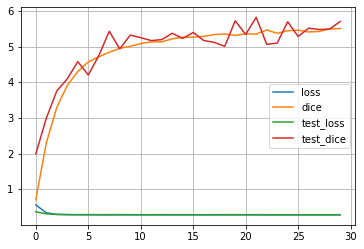

In [38]:
hist_df.plot(grid=True)
plt.show()

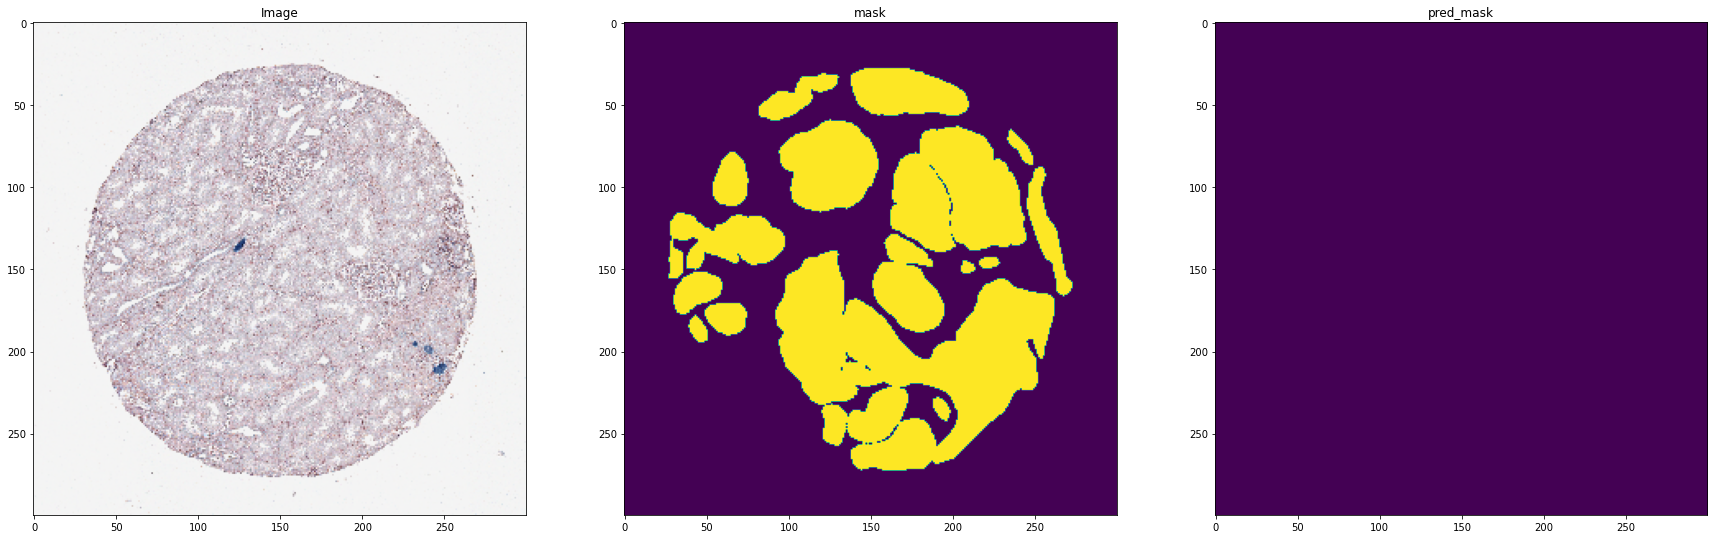

output.shape = torch.Size([2, 300, 300]), pred_mask.shape = torch.Size([300, 300])


In [55]:
model.eval()
with torch.no_grad():
    output = model(one_sample_img.unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(one_sample_img.permute(1, 2, 0).cpu().numpy())
ax1.set_title('Image')
ax2.imshow(torch.argmax(one_sample_mask, axis=0).cpu().numpy())
ax2.set_title('mask')
ax3.imshow(pred_mask.squeeze().cpu().numpy())
ax3.set_title('pred_mask')
plt.show()
print(f"output.shape = {output.shape}, pred_mask.shape = {pred_mask.shape}")